Using device: cuda

Computed class weights: [0.9014682 1.1227143]

Initializing model...


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Model architecture modified for binary classification


Epoch 1 Training:   0%|          | 0/142 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Validation: 100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


Epoch 1: Training Loss: 0.2672, Validation Loss: 0.1086


Validation: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]


Epoch 2: Training Loss: 0.0829, Validation Loss: 0.0966


Validation: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


Epoch 3: Training Loss: 0.0477, Validation Loss: 0.1025


Validation: 100%|██████████| 18/18 [00:08<00:00,  2.05it/s]


Epoch 4: Training Loss: 0.0485, Validation Loss: 0.1265


Validation: 100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


Epoch 5: Training Loss: 0.0233, Validation Loss: 0.1267


Validation: 100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


Epoch 6: Training Loss: 0.0245, Validation Loss: 0.1335


Validation: 100%|██████████| 18/18 [00:09<00:00,  1.82it/s]


Epoch 7: Training Loss: 0.0050, Validation Loss: 0.1337
Early stopping triggered.


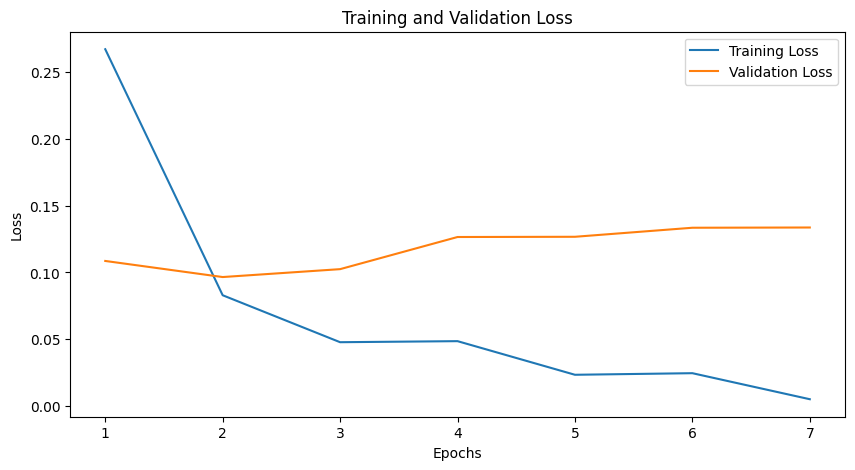

Training complete. Model saved.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score, precision_score, recall_score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tqdm import tqdm
import timm  # Import timm library

# Set device for multiple GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
print(f"Using device: {device}")

# Data Augmentation and Normalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Data
data_dir = '/kaggle/input/waste-classification-data/DATASET/TRAIN'

dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

# Split dataset into train (80%), validation (10%), and test (10%)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Compute Class Weights
train_targets = np.array([dataset[i][1] for i in train_dataset.indices])
class_weights = compute_class_weight('balanced', classes=np.unique(train_targets), y=train_targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("\nComputed class weights:", class_weights.cpu().numpy())

# Model Definition using EfficientNet from timm
print("\nInitializing model...")
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)  # num_classes=0 removes the final classification layer
model = model.to(device)

# Add a custom fully connected network for classification
class CustomClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Get the output size of EfficientNet
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    features = model(dummy_input)
    feature_size = features.shape[1]

# Combine EfficientNet with the custom classifier
class EfficientNetWithClassifier(nn.Module):
    def __init__(self, backbone, classifier):
        super(EfficientNetWithClassifier, self).__init__()
        self.backbone = backbone
        self.classifier = classifier
    
    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits

classifier = CustomClassifier(input_size=feature_size, num_classes=2).to(device)
model = EfficientNetWithClassifier(model, classifier).to(device)
model = nn.DataParallel(model)
torch.compile(model)
print("Model architecture modified for binary classification")

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

# Training Loop
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1} Training'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}: Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")
    
    if early_stopping(val_losses[-1]):
        print("Early stopping triggered.")
        break

# Plot training and validation loss
plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Save the model
torch.save(model.state_dict(), 'best_model.pth')
print("Training complete. Model saved.")


In [4]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
print(classification_report(all_labels, all_preds))

Testing: 100%|██████████| 18/18 [00:22<00:00,  1.26s/it]

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1276
           1       0.95      0.96      0.95       981

    accuracy                           0.96      2257
   macro avg       0.96      0.96      0.96      2257
weighted avg       0.96      0.96      0.96      2257



In [5]:
import os

print(os.listdir('/kaggle/input/waste-classification-data/DATASET'))

['TEST', 'TRAIN']


Feature Maps Shape: (1, 128, 1280, 7, 7)


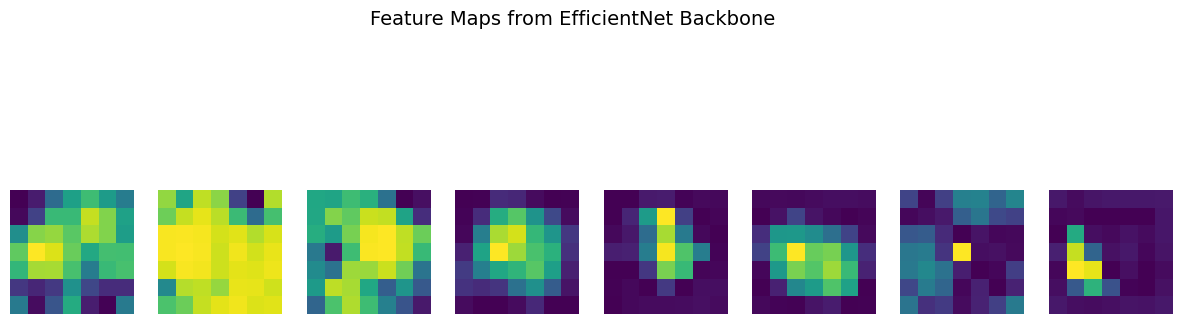

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Ensure your model is in evaluation mode
model.eval()

# If your model is wrapped in DataParallel, get the underlying module
if hasattr(model, 'module'):
    backbone = model.module.backbone
else:
    backbone = model.backbone

# Use the backbone's forward_features method (if available) to extract spatial feature maps
if hasattr(backbone, 'forward_features'):
    feature_extractor = backbone.forward_features
else:
    feature_extractor = backbone

# Function to extract feature maps from one image using the train DataLoader
def extract_feature_maps_from_loader(feature_extractor, dataloader, device):
    feature_maps_list = []
    labels_list = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            # Use forward_features to get convolutional features (spatial maps)
            features = feature_extractor(inputs)
            feature_maps_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
            break  # Process only one batch for visualization
    return np.array(feature_maps_list), np.array(labels_list)

# Extract feature maps using the train DataLoader
feature_maps, labels = extract_feature_maps_from_loader(feature_extractor, train_loader, device)
print("Feature Maps Shape:", feature_maps.shape)  # Expected: (1, batch_size, channels, height, width)

# Function to visualize a few feature maps from the extracted features
def plot_feature_maps(feature_maps, num_maps=8):
    # Select the first image's feature maps from the first batch
    # Original code: feature_maps = feature_maps[0] (incorrect)
    feature_maps = feature_maps[0][0]  # Corrected: first batch, first image
    num_channels = feature_maps.shape[0]
    num_maps = min(num_maps, num_channels)
    
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 5))
    for i in range(num_maps):
        ax = axes[i]
        fmap = feature_maps[i]
        ax.imshow(fmap, cmap='viridis')
        ax.axis('off')
    
    plt.suptitle("Feature Maps from EfficientNet Backbone", fontsize=14)
    plt.show()

# Visualize the feature maps
plot_feature_maps(feature_maps)